# Potential Player Identification System

## ML Based Project by Harshul Shah

This code is designed to recommend football players based on user-defined preferences and statistical analysis. 

1. It first preprocesses the player data and calculates skill category averages.
2. A Random Forest Classifier is used to classify players into mindsets, while K-Means clustering helps identify player clusters and generates regression targets.
3. The code computes weighted scores for players based on user input and filters top players that meet the criteria.
4. It displays the recommended players and visualizes data for deeper insights.


### Step 1: Import Necessary Libraries
In this step, we import the essential libraries needed for data manipulation, machine learning models, visualization, and evaluation. The libraries include:
- `pandas` for data handling
- `sklearn` for machine learning models and metrics
- `plotly` and `matplotlib` for visualizations
- `numpy` and `seaborn` for numerical operations and additional plots


In [14]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score
import numpy as np
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns


### Step 2: Load the Dataset
Here, we load the dataset using `pandas.read_csv()`. The dataset contains player statistics from 2016. Ensure the path to the dataset is correct for your system.


In [15]:
# Load the dataset
file_path = 'C:/Users/Harshul Shah/OneDrive/Documents/Scouting Project/Modified_Players_stat_2016.csv'
data = pd.read_csv(file_path, encoding='latin1')


### Step 3: Preprocess the Dataset
In this step, we clean the data by:
- Dropping rows with missing position values.
- Converting height and weight columns to numeric, filling any NaN values with the median.
- Filling any missing `Contract_Expiry` values with the most common value (mode).
- Ensuring that all skill columns are numeric and filling missing values in them.


In [16]:
# Preprocess the dataset
data = data.dropna(subset=['Club_Position'])  # Drop rows with missing positions

# Convert 'Height' and 'Weight' columns to numeric
data['Height'] = data['Height'].str.replace(' cm', '', regex=False)
data['Weight'] = data['Weight'].str.replace(' kg', '', regex=False)
data['Height'] = pd.to_numeric(data['Height'], errors='coerce')
data['Weight'] = pd.to_numeric(data['Weight'], errors='coerce')
data['Height'] = data['Height'].fillna(data['Height'].median())
data['Weight'] = data['Weight'].fillna(data['Weight'].median())

# Fill missing 'Contract_Expiry' with the mode
if 'Contract_Expiry' in data.columns:
    data['Contract_Expiry'] = data['Contract_Expiry'].fillna(data['Contract_Expiry'].mode()[0])

# Ensure skill columns are numeric and handle missing values
skill_columns = [
    'Ball_Control', 'Dribbling', 'Marking', 'Sliding_Tackle', 'Standing_Tackle',
    'Aggression', 'Reactions', 'Attacking_Position', 'Interceptions',
    'Vision', 'Composure', 'Crossing', 'Short_Pass', 'Long_Pass',
    'Acceleration', 'Speed', 'Stamina', 'Strength', 'Balance', 'Agility',
    'Jumping', 'Heading', 'Shot_Power', 'Finishing', 'Long_Shots', 'Curve',
    'Freekick_Accuracy', 'Penalties', 'Volleys'
]
data[skill_columns] = data[skill_columns].fillna(data[skill_columns].median())


### Step 4: Calculate Skill Category Averages
We calculate the average skill score for each category (technical, tactical, mental, physical) by taking the mean of the relevant columns for each player.


In [17]:
# Define skill categories
categories = {
    'technical': ['Ball_Control', 'Dribbling', 'Crossing', 'Short_Pass', 'Long_Pass', 
                  'Finishing', 'Long_Shots', 'Curve', 'Freekick_Accuracy', 'Penalties', 'Volleys'],
    'tactical': ['Vision', 'Attacking_Position', 'Interceptions', 'Marking'],
    'mental': ['Aggression', 'Reactions', 'Composure'],
    'physical': ['Acceleration', 'Speed', 'Stamina', 'Strength', 'Balance', 'Agility', 'Jumping']
}

# Calculate category averages
for category, columns in categories.items():
    data[category + '_Avg'] = data[columns].mean(axis=1)


### Step 5: Classify Player Mindsets
We define a function to classify players into different mindsets based on their attributes, such as attacking or defensive capabilities. The function assigns a 'Mindset' category to each player, which is then encoded into a numerical label for use in classification.


In [18]:
# Define mindset classification logic
def classify_mindset(row):
    if row['Attacking_Position'] > 70:
        return 'Attacking'
    elif row['Vision'] > 70 and row['Short_Pass'] > 70:
        return 'Playmaker'
    elif row['Interceptions'] > 70 and row['Standing_Tackle'] > 70:
        return 'Defensive'
    else:
        return 'Possession Holding'

# Apply mindset classification
data['Mindset'] = data.apply(classify_mindset, axis=1)

# Encode the target (Mindset) for classification
data['Mindset_Label'] = data['Mindset'].astype('category').cat.codes
target_class = 'Mindset_Label'


### Step 6: Gather User Input for Player Recommendations
We collect user input to specify preferences for player recommendations, such as preferred position, age, and mindset. Users also rate the importance of various skill categories, which will be used to compute a weighted score for players In this step, the user is asked to input certain preferences and parameters to tailor the player recommendations. Here's what each input means:

1. **Preferred player position**: Specifies the position the user is interested in (e.g., CM, LM, RB). This helps filter the data to show players who primarily play in that role.
2. **Maximum age of the player**: Filters players to only include those whose age is equal to or less than the entered value, allowing for age-based selection.
3. **Preferred player mindset**: Refers to the type of play style a player typically exhibits, such as 'Attacking', 'Defensive', 'Playmaker', or 'Possession Holding'. This helps in narrowing down players with the desired strategic focus.

**Skill weights**:
- **Technical skills**: How important are the technical abilities like ball control, dribbling, passing, and shooting for the user's analysis?
- **Tactical skills**: The significance of skills that contribute to gameplay understanding, like vision, positioning, and interceptions.
- **Mental skills**: The value of traits like aggression, composure, and reaction time.
- **Physical skills**: The weight given to attributes such as speed, stamina, strength, and balance.

These inputs directly influence the weighting of the player's average scores across different skill categories, aiding in personalized player recommendations..


In [21]:
# Get user preferences for skill weights
print("\nEnter your preferences for player recommendations:")
user_position = input("Preferred player position (e.g., CM, LM, RB): ")
user_age = int(input("Maximum age of the player: "))
user_mindset = input("Preferred player mindset (Attacking, Defensive, Playmaker, Possession Holding): ")

print("\nRate the importance of the following skills from 0 to 10:")
user_weights = {
    'technical': int(input("Technical skills: ")),
    'tactical': int(input("Tactical skills: ")),
    'mental': int(input("Mental skills: ")),
    'physical': int(input("Physical skills: "))
}
# Normalize weights
total_weight = sum(user_weights.values())
user_weights = {k: v / total_weight for k, v in user_weights.items()}



Enter your preferences for player recommendations:


Preferred player position (e.g., CM, LM, RB):  CM
Maximum age of the player:  30
Preferred player mindset (Attacking, Defensive, Playmaker, Possession Holding):  Attacking



Rate the importance of the following skills from 0 to 10:


Technical skills:  8
Tactical skills:  7
Mental skills:  8
Physical skills:  9


### Step 7: Compute Weighted Scores for Players
We calculate a weighted score for each player based on user preferences, which considers the importance of each skill category. This score will help in ranking players for recommendations.


In [22]:
# Compute player scores based on user weights
def compute_weighted_score(row):
    score = 0
    for category, weight in user_weights.items():
        score += weight * row[category + '_Avg']
    return score

data['Weighted_Score'] = data.apply(compute_weighted_score, axis=1)


### Step 8: Train a Random Forest Classifier
We train a Random Forest Classifier to predict player mindsets based on their skill averages. We split the data into training and testing sets, fit the model, and evaluate its accuracy on both sets.


In [23]:
# Step 1: Random Forest Classification
X_class = data[[cat + '_Avg' for cat in categories.keys()]]
y_class = data[target_class]
X_train_class, X_test_class, y_train_class, y_test_class = train_test_split(
    X_class, y_class, test_size=0.3, random_state=42)

# Train Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=42, n_estimators=100)
rf_classifier.fit(X_train_class, y_train_class)

# Evaluate classification performance
y_pred_train_class = rf_classifier.predict(X_train_class)
y_pred_test_class = rf_classifier.predict(X_test_class)
train_accuracy = accuracy_score(y_train_class, y_pred_train_class)
test_accuracy = accuracy_score(y_test_class, y_pred_test_class)


### Step 9: Apply K-Means Clustering for Regression
We apply K-Means clustering to group players into clusters, using cluster centers as regression targets for further analysis. We evaluate the performance of the regression model using Mean Squared Error (MSE).


In [24]:
# Step 2: K-Means Regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_class)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
data['Cluster'] = kmeans.fit_predict(X_scaled)

# Use cluster centers as regression targets
regression_targets = kmeans.cluster_centers_.mean(axis=1)
data['Regression_Target'] = data['Cluster'].map(dict(enumerate(regression_targets)))

# Split data for regression
y_reg = data['Regression_Target']
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_scaled, y_reg, test_size=0.3, random_state=42)

# Predict and evaluate regression performance
y_pred_train_reg = kmeans.predict(X_train_reg)
y_pred_test_reg = kmeans.predict(X_test_reg)
train_mse = mean_squared_error(y_train_reg, y_pred_train_reg)
test_mse = mean_squared_error(y_test_reg, y_pred_test_reg)


### Step 10: Filter and Display Top Players
We filter the data based on user preferences and sort the filtered players by their weighted scores. We display the top 5 players matching the criteria.


In [25]:
# Step 3: Player Recommendations
filtered_players = data[
    (data['Club_Position'] == user_position) &
    (data['Age'] <= user_age) &
    (data['Mindset'] == user_mindset)
].sort_values(by='Weighted_Score', ascending=False)

# Display top 5 players
columns_to_display = ['Name', 'Club', 'Club_Position', 'Contract_Expiry', 'Age']
if 'Preferred_Foot' in data.columns:
    columns_to_display.append('Preferred_Foot')

top_players = filtered_players[columns_to_display + ['Weighted_Score']].head(5)

# Display results
if not top_players.empty:
    print("\nPotential Players Based on Your Preferences:")
    print(top_players.rename(
        columns={
            'Name': 'Player Name',
            'Club': 'Club',
            'Club_Position': 'Position',
            'Contract_Expiry': 'Contract Expiry',
            'Preferred_Foot': 'Preferred Foot',
            'Weighted_Score': 'Player Score'
        }
    ).to_string(index=False))
else:
    print("\nNo players match your criteria. Try adjusting your inputs.")



Potential Players Based on Your Preferences:
   Player Name        Club Position  Contract Expiry  Age  Player Score
         Pizzi  SL Benfica       CM           2022.0   27     77.219596
  Adrien Silva Sporting CP       CM           2020.0   28     76.722538
Renato Sanches   FC Bayern       CM           2021.0   19     76.531149
         Allan      Napoli       CM           2019.0   26     76.430499
 AndrÃ© AndrÃ©    FC Porto       CM           2019.0   27     75.342330


### Step 11: Generate Visualizations
We create visualizations to better understand the data and present player analysis:
- A bar chart to show the scores of the top 5 recommended players.
- A scatter plot to show the distribution of players based on age and weighted score.
- A histogram to visualize the distribution of a specific skill, e.g., 'Ball_Control'.



Generating visualizations...

Generating Bar Chart...


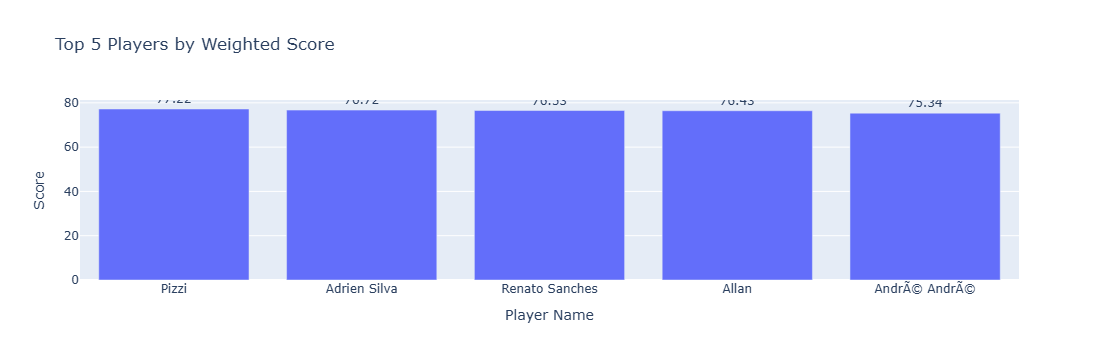


Generating Scatter Plot...


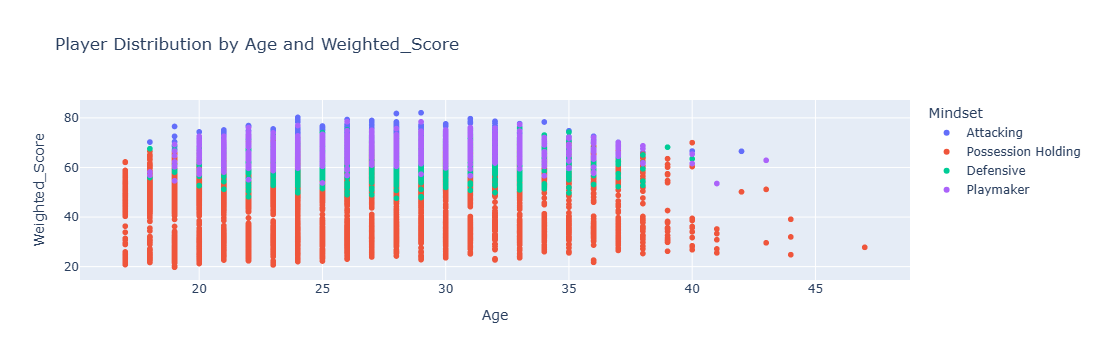


Generating Histogram...


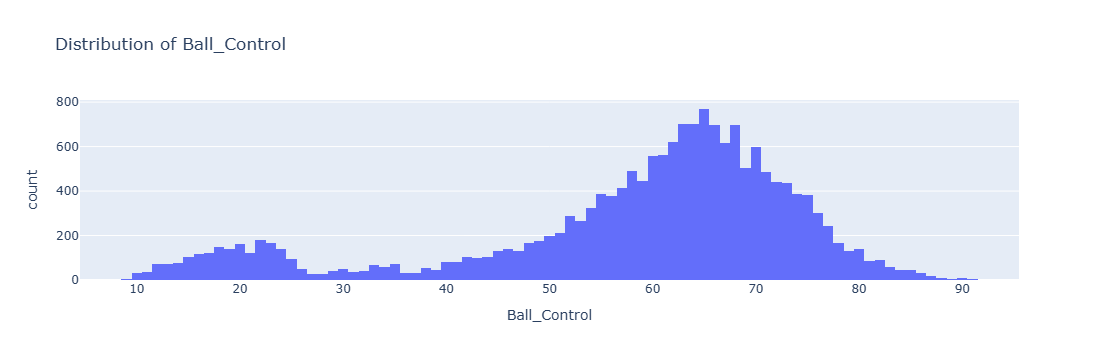

In [26]:
# 2. **Bar Chart for Top Players' Scores**
def bar_chart(top_players):
    fig = px.bar(top_players, x='Name', y='Weighted_Score', text='Weighted_Score',
                 title='Top 5 Players by Weighted Score',
                 labels={'Name': 'Player Name', 'Weighted_Score': 'Score'})
    fig.update_traces(texttemplate='%{text:.2f}', textposition='outside')
    fig.show()

# 3. **Interactive Scatter Plot for Player Distribution**
def scatter_plot(data, x='Age', y='Weighted_Score', color='Mindset'):
    fig = px.scatter(data, x=x, y=y, color=color, hover_name='Name',
                     title=f'Player Distribution by {x} and {y}',
                     labels={x: x, y: y})
    fig.show()

# 4. **Histogram for Skill Distribution**
def histogram(data, skill_column):
    fig = px.histogram(data, x=skill_column, title=f'Distribution of {skill_column}',
                        labels={skill_column: skill_column})
    fig.show()

# Run visualizations for the top players
if not top_players.empty:
    print("\nGenerating visualizations...")

    # Bar Chart
    print("\nGenerating Bar Chart...")
    bar_chart(top_players)

    # Scatter Plot
    print("\nGenerating Scatter Plot...")
    scatter_plot(data)

    # Histogram for a skill (e.g., 'Ball_Control')
    print("\nGenerating Histogram...")
    histogram(data, 'Ball_Control')


### Final Step: Display Evaluation Metrics
We print the evaluation results of the Random Forest Classifier and K-Means regression models, showing their accuracy and mean squared error values for training and testing data.


In [27]:
# Display results
print("\nRandom Forest Classification Results:")
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Testing Accuracy: {test_accuracy:.2f}")

print("\nK-Means Regression Results:")
print(f"Training MSE: {train_mse:.2f}")
print(f"Testing MSE: {test_mse:.2f}")



Random Forest Classification Results:
Training Accuracy: 1.00
Testing Accuracy: 0.85

K-Means Regression Results:
Training MSE: 6.34
Testing MSE: 6.36
